In [1]:
import gurobipy as gp
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

%matplotlib inline

from markowitz import Markowitz

In [2]:
def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

### Leitura e pré-processamento dos dados de entrada:

In [3]:
df = pd.read_excel('seriehistorica10anos.xlsx')
df.fillna(method='ffill',inplace=True)
df.rename(columns={df.columns[0]: 'datas'},
          inplace=True, errors='raise')

df['datas'] = pd.to_datetime(df['datas'])
df.set_index('datas', inplace = True)

### PARA DROPAR AS ENTRADAS NULAS:
#df = df[(df != 0).all(1)]

### PARA APLICAR UMA INTERPOLAÇÃO NO PERÍODO 
df = df.replace(0, pd.NA).interpolate()

In [15]:
#for col in df:
#    print(df[col] [df[col] <= 0.0001])

In [5]:
#df['11182072000113']['2019-02']

In [6]:
#df['11182072000113']['2019-02'].replace(0, pd.NA).interpolate()

#fig = plt.figure() 
#plt.figure(figsize=(16,12))
#plt.plot(df['11182072000113']['2019-02'].replace(0, pd.NA).interpolate())
#plt.plot(df['11182072000113']['2019-02'])
#plt.ylim((4.5,5.5))
#plt.grid()
#plt.show()


In [4]:
datas = list(df.index.astype(str))
aux = [i[0:4] for i in datas]
anos = pd.Series(aux).unique().tolist()

limites_anos = [0]

a = 0

for c in anos:
    a += aux.count(c)
    limites_anos.append(a)

print(anos)

['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021']


In [5]:
limites_anos

[0, 82, 333, 586, 839, 1089, 1340, 1589, 1839, 2092, 2348, 2522]

### Construção de DF_anos e DF_meses (Não utilizados na atual implementação)

In [6]:
DF_anos = dict()

for k in anos:
    DF_anos[k] = df.loc[k].copy()

In [7]:
DF_meses = dict()

for j in anos:
    for k in range(1, 13):
        try:
            DF_meses[j, str(k).zfill(2)] = df.loc[j + '-' + str(k)].copy()
        except:
            pass
        
DF_meses.keys()

dict_keys([('2011', '09'), ('2011', '10'), ('2011', '11'), ('2011', '12'), ('2012', '01'), ('2012', '02'), ('2012', '03'), ('2012', '04'), ('2012', '05'), ('2012', '06'), ('2012', '07'), ('2012', '08'), ('2012', '09'), ('2012', '10'), ('2012', '11'), ('2012', '12'), ('2013', '01'), ('2013', '02'), ('2013', '03'), ('2013', '04'), ('2013', '05'), ('2013', '06'), ('2013', '07'), ('2013', '08'), ('2013', '09'), ('2013', '10'), ('2013', '11'), ('2013', '12'), ('2014', '01'), ('2014', '02'), ('2014', '03'), ('2014', '04'), ('2014', '05'), ('2014', '06'), ('2014', '07'), ('2014', '08'), ('2014', '09'), ('2014', '10'), ('2014', '11'), ('2014', '12'), ('2015', '01'), ('2015', '02'), ('2015', '03'), ('2015', '04'), ('2015', '05'), ('2015', '06'), ('2015', '07'), ('2015', '08'), ('2015', '09'), ('2015', '10'), ('2015', '11'), ('2015', '12'), ('2016', '01'), ('2016', '02'), ('2016', '03'), ('2016', '04'), ('2016', '05'), ('2016', '06'), ('2016', '07'), ('2016', '08'), ('2016', '09'), ('2016', '10'

### Parâmetros de entrada do modelo:

In [145]:
minRetorno = 0.1
C = 100_000
P_categorias = [0.00, 0.00, 0.00, 1.0]
K_min = 3
K_max = 10
P_min = 0.05
P_max = 0.3
l = 1
log = 0

### Seleção do Período do Estudo - O período final é onde a janela TERMINA, e não o início do período final:

In [146]:
ano_inicial = 2012
ano_final = 2017
mes_inicial = 1
mes_final = 1
intervalo_mensal = 6

In [147]:
tam_treinamento = 252
tam_teste = 126
inicio_treinamento = 0
final_treinamento = inicio_treinamento + tam_treinamento
inicio_teste = final_treinamento + 1
final_teste = inicio_teste + tam_teste

cnpj = list(pf_ordered.index)

DF_retorno_completo = df.pct_change().dropna()

matriz_pesos = DF_retorno_completo.copy()
matriz_pesos = matriz_pesos * 0

while(final_teste <= DF_retorno_completo.shape[0]):
    minRetorno = 0
    a_retorno = []
    a_risco = []
    a_sharpe = []

    RES = dict()
    k = 0
    
    DF_retorno_treinamento = DF_retorno_completo.iloc[inicio_treinamento:final_treinamento]
   
    sigma = (DF_retorno_treinamento.cov() * 252).to_numpy()
    media = (DF_retorno_treinamento + 1).apply(geo_mean)**252-1

    tempo_init = time.time()
    while minRetorno <= 0.2:
        print('minRetorno atual:', minRetorno)
        Carteira = modelo.solve(time = 15)
        if(Carteira.Retorno != 0):
            a_retorno.append(Carteira.Retorno)
            a_risco.append(Carteira.Risco)
            a_sharpe.append((Carteira.Retorno - 0.0525)/Carteira.Risco)
        else:
            break
        RES[k] = Carteira
        minRetorno = minRetorno + 0.02
        modelo.update_minRetorno(minRetorno)
        k += 1
    max_i = np.argmax(a_sharpe)
    Carteira = RES[max_i]
    #modelo = Markowitz(C, minRetorno, K_min, K_max, P_min, P_max, P_categorias, limites,
    #n, minFundos, sigma, media, cnpj)
    #Carteira = modelo.solve()
    print('Tempo total:', time.time() - tempo_init, 's')

    Carteira.exibir(C)

    hist[str(inicio_treinamento), str(final_treinamento)] = Carteira
#    print('Resultado referente a slice: ', inicio_treinamento + '-' + final_treinamento)
    print('\n')
    print('###############################################')
    print('\n')

    for idx, cnpj_loop in enumerate(Carteira.descricao):
        matriz_pesos[cnpj_loop][inicio_teste:final_teste] = Carteira.porcentagem[idx]
    
    inicio_treinamento += tam_teste
    final_treinamento += tam_teste
    
    inicio_teste += tam_teste
    final_teste += tam_teste

Tempo total: 2.141122579574585 s
Retorno esperado --> 10.22%
Risco estimado --> 0.1%
Fundo 129 (09543255000175) --> 30.0%; R$ 30000.0 --> R$ 1000.0
Fundo 134 (02536364000116) --> 30.0%; R$ 30000.0 --> R$ 1000.0
Fundo 137 (04899128000190) --> 30.0%; R$ 30000.0 --> R$ 1000.0
Fundo 141 (08610270000126) --> 5.0%; R$ 5000.0 --> R$ 100.0
Fundo 151 (11447124000136) --> 5.0%; R$ 5000.0 --> R$ 1000.0


###############################################


Tempo total: 1.332076072692871 s
Retorno esperado --> 10.0%
Risco estimado --> 0.65%
Fundo 128 (09814233000100) --> 6.3%; R$ 6304.6 --> R$ 3000.0
Fundo 129 (09543255000175) --> 5.0%; R$ 5000.0 --> R$ 1000.0
Fundo 130 (10326625000100) --> 30.0%; R$ 30000.0 --> R$ 1000.0
Fundo 149 (10783480000168) --> 18.66%; R$ 18657.2 --> R$ 100.0
Fundo 150 (13554383000191) --> 5.04%; R$ 5038.2 --> R$ 5000.0
Fundo 151 (11447124000136) --> 5.0%; R$ 5000.0 --> R$ 1000.0
Fundo 152 (13615411000133) --> 30.0%; R$ 30000.0 --> R$ 5000.0


################################

datas
2011-09-05    1.000000
2011-09-06    1.000000
2011-09-08    1.000000
2011-09-09    1.000000
2011-09-12    1.000000
                ...   
2021-08-30    1.788067
2021-08-31    1.784056
2021-09-01    1.785233
2021-09-02    1.780417
2021-09-03    1.779670
Length: 2521, dtype: float64

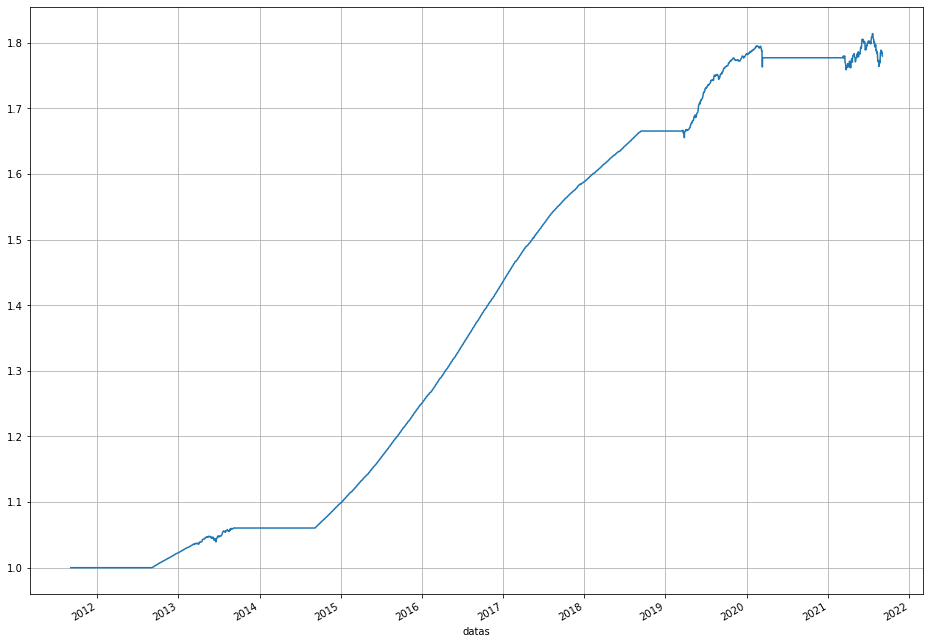

In [148]:

((matriz_pesos.iloc[255][:]) * (DF_retorno_completo.iloc[255][:])).sum()

retorno_perc_carteira = (matriz_pesos * DF_retorno_completo).sum(axis=1)

retorno_acum_carteira = (retorno_perc_carteira + 1).cumprod()
retorno_acum_carteira.plot(figsize = (16,12), grid=True)
retorno_acum_carteira

#retorno_acum_carteira_arrojado = retorno_acum_carteira.copy()

In [138]:
from math import pow

pow(2.674955, 1/9.5)

1.1091254791572343

In [26]:
mes_atual = mes_inicial
anos_escolhidos = [str(j) for j in range(ano_inicial, ano_final + 1)]
datas_escolhidas = list()
for i in anos_escolhidos:
    while(True):
        if( (int(i) == ano_final) and (mes_atual > mes_final)):
            break
        datas_escolhidas.append( (i, str(mes_atual).zfill(2)) )
        if (mes_atual + intervalo_mensal) <= 12:
            mes_atual += intervalo_mensal
        else:
            mes_atual = (mes_atual + intervalo_mensal) % 12
            break

datas_escolhidas

[('2012', '01'),
 ('2012', '06'),
 ('2012', '11'),
 ('2013', '04'),
 ('2013', '09'),
 ('2014', '02'),
 ('2014', '07'),
 ('2014', '12'),
 ('2015', '05'),
 ('2015', '10'),
 ('2016', '03'),
 ('2016', '08'),
 ('2017', '01')]

## LOOP Principal: Resolvendo os modelos em cada período da janela rolante:

In [11]:
import time

hist = dict()

pf = pd.read_excel('perfilfundos.xlsx', usecols = ['CNPJ', 'APLICACAO_MINIMA', 'CATEGORIA', 'SUBCATEGORIA'])
pf['CNPJ'] = pf['CNPJ'].apply(lambda x: re.sub('\W+', '', x))
pf['APLICACAO_MINIMA'] = pd.to_numeric(pf['APLICACAO_MINIMA'].apply(lambda x : re.sub('\D+', '', x)), errors='coerce')
pf.fillna(0, inplace=True)
pf.set_index('CNPJ',inplace=True)
pf_ordered = pf.sort_values(by ='CATEGORIA')
pf_ordered.drop(index=(list(set(pf.index)-set(df.columns))),inplace=True)

cnpj = list(pf_ordered.index)
    
df = df[cnpj]
categorias = list(pf_ordered['CATEGORIA'].unique())
limites = [0]
a = 0
for c in categorias:
    a += len(pf_ordered[pf_ordered['CATEGORIA'] == c])
    limites.append(a)

minFundos = np.array(pf_ordered['APLICACAO_MINIMA'])

n = len(minFundos)

    
DF_iteracao = None

if(len(datas_escolhidas) <= 1):
    print('--- CASO ANTERIOR ---')
else:
    for idx in range(len(datas_escolhidas) - 1):
        DF_iteracao = df.loc[datas_escolhidas[idx][0]+'-'+datas_escolhidas[idx][1] : 
                             datas_escolhidas[idx+1][0]+'-'+datas_escolhidas[idx+1][1]]
        
        df_retorno = DF_iteracao.pct_change().dropna()
        sigma = (df_retorno.cov()*252).to_numpy()
        media = (df_retorno+1).apply(geo_mean)**252-1

        tempo_init = time.time()
        modelo = Markowitz(C, minRetorno, K_min, K_max, P_min, P_max, P_categorias, limites,
        n, minFundos, sigma, media, cnpj)
        Carteira = modelo.solve()
        print('Tempo total:', time.time() - tempo_init, 's')

        Carteira.exibir(C)

        hist[datas_escolhidas[idx][0], datas_escolhidas[idx][1]] = Carteira
        print('Resultado referente ao periodo: ', datas_escolhidas[idx][0] + '-' + datas_escolhidas[idx][1])
        print('\n')
        print('###############################################')
        print('\n')
        
        DF_iteracao = None

Academic license - for non-commercial use only - expires 2021-11-05
Using license file C:\Users\Eduardo\gurobi.lic
Tempo total: 11.352649450302124 s
Retorno esperado --> 14.46%
Risco estimado --> 1.49%
Fundo 5 (12287682000144) --> 5.0%; R$ 5000.0 --> R$ 5000.0
Fundo 24 (09599346000122) --> 5.0%; R$ 5000.0 --> R$ 500.0
Fundo 28 (06118222000190) --> 5.0%; R$ 5000.0 --> R$ 5000.0
Fundo 38 (06070574000112) --> 10.0%; R$ 10000.0 --> R$ 10000.0
Fundo 68 (13001211000190) --> 30.0%; R$ 30000.0 --> R$ 5000.0
Fundo 125 (12120451000141) --> 5.0%; R$ 5000.0 --> R$ 1000.0
Fundo 138 (05755769000133) --> 20.0%; R$ 20000.0 --> R$ 20000.0
Fundo 145 (12923387000137) --> 20.0%; R$ 20000.0 --> R$ 500.0
Resultado referente ao periodo:  2012-01


###############################################


Tempo total: 19.05308985710144 s
Retorno esperado --> 10.43%
Risco estimado --> 1.21%
Fundo 8 (09120774000120) --> 5.0%; R$ 5000.0 --> R$ 5000.0
Fundo 12 (12987743000186) --> 5.0%; R$ 5000.0 --> R$ 5000.0
Fundo 28 (

## Plot "validação" para um fundo:

    -) Em azul: a série temporal usada para a previsão dos retornos;
    -) Em vermelho: a série temporal dos seis próximos meses (período do investimento);
    -) Em laranja: a série temporal do mês após o final do investimento.

Retorno esperado --> 14.46%
Risco estimado --> 1.49%
Fundo 5 (12287682000144) --> 5.0%; R$ 5000.0 --> R$ 5000.0
Fundo 24 (09599346000122) --> 5.0%; R$ 5000.0 --> R$ 500.0
Fundo 28 (06118222000190) --> 5.0%; R$ 5000.0 --> R$ 5000.0
Fundo 38 (06070574000112) --> 10.0%; R$ 10000.0 --> R$ 10000.0
Fundo 68 (13001211000190) --> 30.0%; R$ 30000.0 --> R$ 5000.0
Fundo 125 (12120451000141) --> 5.0%; R$ 5000.0 --> R$ 1000.0
Fundo 138 (05755769000133) --> 20.0%; R$ 20000.0 --> R$ 20000.0
Fundo 145 (12923387000137) --> 20.0%; R$ 20000.0 --> R$ 500.0


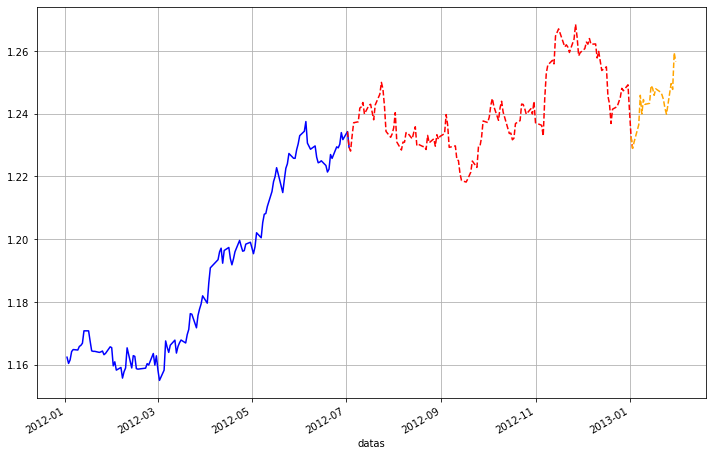

In [21]:
hist['2012', '01'].exibir(C)

fundo = '13001211000190'
fundo_ruim = '12120451000141'

df['2012-01':'2012-07-03'][fundo].plot(style = '-b', figsize = (12, 8))
df['2012-07':'2013-01-03'][fundo].plot(style = '--r')
fig = df['2013-01'][fundo].plot(style = '--', color='orange', grid=True)

#fig.get_figure().savefig('Figura1.pdf')

In [110]:
#sigma[63]


In [111]:
print(hist.keys())
print()

#Hist['2014', '01'].exibir(C)

dict_keys([('2012', '01'), ('2012', '07'), ('2013', '01'), ('2013', '07'), ('2014', '01'), ('2014', '07'), ('2015', '01'), ('2015', '07'), ('2016', '01')])



# Previsão X Resultado - Ano de 2012:

`Observação:` Os dados foram convertidos em **escores Z** para o plot poder ser colocado em escala!

### Saída do modelo - Fundos escolhidos tomando por base o período 2012/01 ~ 2012/06:

In [12]:
import cufflinks as cf
from plotly.offline import plot, iplot

cf.go_offline()

dados_periodo = df.loc['2012-01':'2012-06']

cnpj_periodo = hist['2012', '01'].descricao

series_temp = dados_periodo[cnpj_periodo]

series_temp = (series_temp - series_temp.mean())/series_temp.std()

series_temp.iplot()


### Seis próximos meses - Resultado da aplicação selecionada

In [13]:
import cufflinks as cf
from plotly.offline import plot, iplot

cf.go_offline()

dados_periodo = df.loc['2012-07':'2013-01']

cnpj_periodo = hist['2012', '01'].descricao

series_temp = dados_periodo[cnpj_periodo]

series_temp = (series_temp - series_temp.mean())/series_temp.std()

series_temp.iplot()


In [186]:
resultados

res_np = np.array(resultados)

res_np = res_np.cumprod() * 100_000

res_np

array([100000.        , 107484.58522045, 112474.08125082, 114901.4144954 ,
       120487.59613705, 125413.96220481, 132281.97131165, 140017.425728  ,
       147503.47828999])

[1.0,
 1.0748458522045312,
 1.0464205729606042,
 1.0215812675915077,
 1.0486171703471348,
 1.0408869147173967,
 1.0547627152997792,
 1.058477011943858,
 1.053465149234619]

In [182]:
res_pd = pd.DataFrame(res_np)

res_pd.columns = ['Capital']
res_pd.index = ['01/2012', '07/2012', '01/2013', '07/2013', '01/2014', '07/2014', '01/2015', '07/2015', '01/2016']
res_pd

,Capital
01/2012,100000.000000
07/2012,107484.585220
01/2013,112474.081251
07/2013,114901.414495
01/2014,120487.596137
07/2014,125413.962205
01/2015,132281.971312
07/2015,140017.425728
01/2016,147503.478290


C:\Users\Eduardo\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


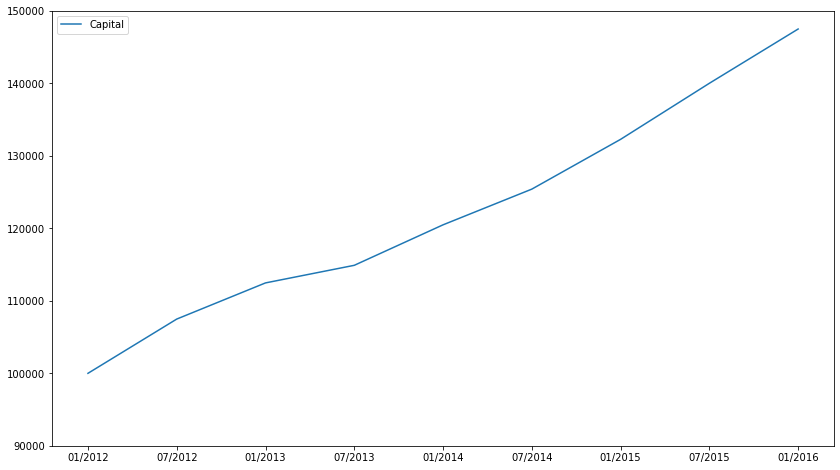

In [194]:
figura = res_pd.plot(figsize = (14,8), ylim = (90_000, 150_000))


In [ ]:
fig = plt.figure() 
plt.figure(figsize=(8,6))
plt.plot(res_np)
plt.grid()
#plt.xlabel('VOLATILIDADE ESPERADA')
#plt.ylabel('RETORNO ESPERADO')
#plt.savefig('conservador.pdf')
plt.show()